In [1]:
from math import sqrt
import random

START_CITY = (1, 39)
OTHER_CITIES = [(75, 55), (2, 8), (45, 26), (46, 10), (49, 90), (70, 65), (1, 2), (71, 81), (36, 63), (62, 70), (97, 2), (4, 4), (89, 37), (66, 12), (69, 84), (81, 35), (42, 33), (14, 78), (24, 82), (97, 21), (26, 79), (38, 71), (75, 34), (86, 1), (79, 76), (24, 48), (34, 83), (2, 43), (77, 28), (36, 9), (32, 61), (57, 81), (59, 25), (19, 20), (16, 78), (30, 88), (15, 52), (42, 85), (95, 70)]

def dist(a, b):
    return sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

class Route:
    def get_cost(self):
        total = 0
        for i in range(38):
            total += dist(self.cities[i], self.cities[i+1])
        total += dist(START_CITY, self.cities[0])
        total += dist(START_CITY, self.cities[-1])
        return total

    def __init__(self, route):
        assert len(route) == 39 #this checks if the route has exactly 39 cities.  If not, an exception is thrown
        assert all([city in route for city in OTHER_CITIES])    #this makes sure each city in OTHER_CITIES is in the route
        #together, the two above lines make sure the route is an ordering of the OTHER_CITIES
        self.cities = route
        self.fitness = -1 * self.get_cost()
    
    def __repr__(self):
        return f'Route({self.cities})'
    
    @staticmethod
    def random():
        cities = OTHER_CITIES[:]
        random.shuffle(cities)
        return Route(cities)

PARENT SELECTION METHODS:

Input: the population to be selected from, as a list in no particular order

Output: a list of size 2*OFFSPRING_SIZE, representing the selected parents

Constraints: the order of population can be changed, but the list should not be modified

In [2]:
def random_selection(population):
    mating_pool = []
    for i in range(2*OFFSPRING_SIZE):
        mating_pool.append(random.choice(population))
    return mating_pool

#this requires SELECTION_K to be specified
def selection_k_tournament(population):
    mating_pool = []
    for i in range(2*OFFSPRING_SIZE):
        entrants = random.sample(population, k=SELECTION_K)    #pick k random people from the population to go into a tournament
        winner = max(entrants, key=lambda x:x.fitness)  #find the entrant with the highest fitness
        mating_pool.append(winner)  #put the winner in the mating pool
    return mating_pool

CROSSOVER METHODS:

Input: the dna of two parents (each is a list of cities)

Output: a new list of cities, representing the child's dna

Constraints: the dna of the parents should not be modified

In [3]:
def copy_first_n(dna1, dna2):
    child = dna1[:random.randint(1, 38)]
    for city in dna2:
        if city not in child:
            child.append(city)
    return child

#this one's complicated: https://www.rubicite.com/Tutorials/GeneticAlgorithms/CrossoverOperators/CycleCrossoverOperator.aspx
def cycle_crossover(dna1, dna2):
    cycle_num = [0 for i in range(len(dna1))]
    cycle = 1   #which cycle we're on
    while(not all(cycle_num)): #0 is "falsy" in python, so this checks if any of the cycle_nums are still 0
        index = cycle_num.index(0)
        starting_value = dna1[index]
        cur_value = dna2[index]
        cycle_num[index] = cycle    #mark point as belonging to this cycle
        while cur_value != starting_value:
            index = dna1.index(cur_value)
            cur_value = dna2[index]
            cycle_num[index] = cycle
        cycle += 1
    return [dna1[i] if cycle_num[i]%2 else dna2[i] for i in range(len(dna1))]

MUTATION METHODS:

Input: A list of cities, representing DNA to mutate

Output: A list of cities, representing the mutated DNA

Constraints: None.  The input list may be changed, as it is discarded after calling.

In [4]:
def no_mutation(dna):
    return dna

def swap_mutation(dna):
    i = random.randrange(len(dna))
    j = random.randrange(len(dna))
    dna[i], dna[j] = dna[j], dna[i]
    return dna

def flip_mutation(dna):
    #pick two random points and flip the subarray bounded by those
    #Example: If the sequence is [A,B,C,D,E,F] and B and E are selected,
    #the new sequence is [A,E,D,C,B,F]
    i = random.randrange(len(dna))
    j = random.randrange(len(dna))
    start = min(i,j)
    stop = max(i,j)
    return dna[:start] + dna[start:stop][::-1] + dna[stop:]

def insert_mutation(dna):
    #pick two random points and insert the city at one point into the other, shifting all other cities to make room
    #Example: If the sequence is [A,B,C,D,E,F] and we chose to insert E at B,
    #the new sequence is [A,E,B,C,D,F]
    city = dna.pop(random.randrange(len(dna)))
    dna.insert(random.randrange(len(dna)), city)
    return dna

SURVIVAL METHODS:

Input: The parents and children to chose from, each as a list in no particular order

Output: A list of size POPULATION_SIZE representing the organisms that survive

Constraints: The output should have unique elements; a parent/child should not survive multiple times.  The parent and children lists can be modified however you want.

In [5]:
def truncation(population, children):
    return sorted(population+children, key=lambda x:x.fitness, reverse=True)[:POPULATION_SIZE]

#keep the k most fit parents, and then however many children we need to fill out the population
#requires SURVIVAL_K to be specified.  SURVIVAL_K + OFFSPRING_SIZE must be greater than or equal to POPULATION_SIZE
def k_elitism(population, children):
    if len(children)+SURVIVAL_K < POPULATION_SIZE:
        raise ValueError("If using k-elitism, SURVIVAL_K plus OFFSPRING_SIZE must be at least POPULATION_SIZE")
    population.sort(key=lambda x:x.fitness, reverse=True)
    children.sort(key=lambda x:x.fitness, reverse=True)
    return population[:SURVIVAL_K] + children[:POPULATION_SIZE - SURVIVAL_K]

def k_tournament_survival(population, children):
    pool = population + children
    survivors = []
    for i in range(POPULATION_SIZE):
        entrants = random.sample(pool, k=SURVIVAL_K)    #pick k random people from the population to go into a tournament
        winner = max(entrants, key=lambda x:x.fitness)  #find the entrant with the highest fitness
        survivors.append(winner)
        pool.remove(winner)
    return survivors

In [23]:
POPULATION_SIZE = 100
OFFSPRING_SIZE = 150
MUTATION_RATE = 0.25
GENERATIONS = 3000

SELECTION_K = 4 #only used if using tournament parent selection
SURVIVAL_K  = 4 #only used if using elitist or tournament survival

selection_method = selection_k_tournament
crossover_method = cycle_crossover
mutation_method  = swap_mutation
survival_method  = k_elitism

In [24]:
random.seed()

population = [Route.random() for i in range(POPULATION_SIZE)]
best = max(population, key=lambda x:x.fitness)

for gen in range(GENERATIONS):
    #pick parents and crossover
    parents = selection_method(population)
    assert len(parents) == 2*OFFSPRING_SIZE
    child_dna = [crossover_method(parents[i].cities, parents[i+1].cities) for i in range(0,len(parents),2)]
    #turn dna into children
    children = []
    for i in range(len(child_dna)):
        if random.random() < MUTATION_RATE:
            new_dna = mutation_method(child_dna[i])
            children.append(Route(new_dna))
        else:
            children.append(Route(child_dna[i]))
    #choose the survivors:
    population = survival_method(parents, children)
    assert len(population) == POPULATION_SIZE
    best = max(population+[best], key=lambda x:x.fitness)
    #print progress
    if gen>0 and 10*gen % GENERATIONS == 0:
        print(f"{100*gen // GENERATIONS}% done.  Best fitness: {best.fitness}")

print(f"Best fitness: {best.fitness}")
print(best)

10% done.  Best fitness: -773.8710545118844
20% done.  Best fitness: -773.8710545118844
30% done.  Best fitness: -773.8710545118844
40% done.  Best fitness: -773.8710545118844
50% done.  Best fitness: -773.8710545118844
60% done.  Best fitness: -773.8710545118844
70% done.  Best fitness: -773.8710545118844
80% done.  Best fitness: -773.8710545118844
90% done.  Best fitness: -773.8710545118844
Best fitness: -773.8710545118844
Route([(14, 78), (16, 78), (26, 79), (24, 82), (30, 88), (34, 83), (59, 25), (66, 12), (86, 1), (97, 2), (97, 21), (89, 37), (95, 70), (75, 55), (81, 35), (77, 28), (75, 34), (36, 63), (32, 61), (2, 8), (1, 2), (4, 4), (19, 20), (69, 84), (71, 81), (79, 76), (70, 65), (62, 70), (57, 81), (49, 90), (42, 85), (38, 71), (36, 9), (46, 10), (45, 26), (42, 33), (24, 48), (15, 52), (2, 43)])


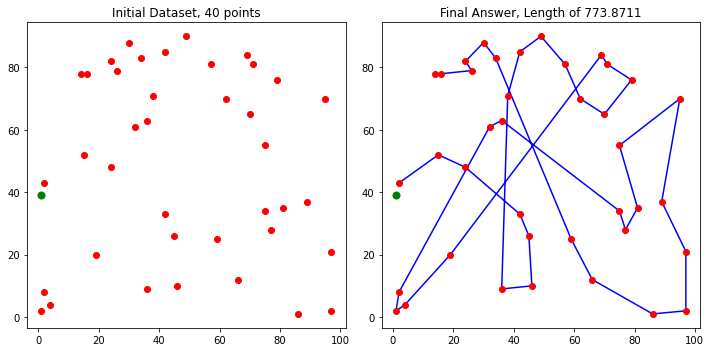

In [25]:
import matplotlib.pyplot as plt
import numpy as np

fig, [ax1,ax2] = plt.subplots(1,2, figsize=(10,5))
c = np.array(OTHER_CITIES)
s = np.array(best.cities)
ax1.plot(c[:, 0], c[:, 1], marker='o', linewidth=0, color='red')
ax1.plot(START_CITY[0], START_CITY[1], marker='.', mew=3, ms=10, linewidth=0, color='green')
ax1.set(title=f'Initial Dataset, {len(OTHER_CITIES) + 1} points')

ax2.plot(s[:, 0], s[:, 1], marker='o', color='b', mfc='r',mec='r')
ax2.plot(START_CITY[0], START_CITY[1], marker='.', mew=3, ms=10, linewidth=0, color='green')
ax2.set(title=f'Final Answer, Length of {-1 * best.fitness:.4f}')

fig.tight_layout()
plt.show()